# Assignment 2

In this section we will have an original task: Given a question, how do you know if it was a genuine question from someone who are searching for an answer, or merely asked for some other reasons?

## Input Data
### Load libraries

Nothing new here.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load dataset

The dataset is part of **Quora's <a href="https://www.kaggle.com/c/quora-insincere-questions-classification/data">Insincere Questions Classification</a> Competition**. You are free to explore the data as you see fit.

In [2]:
df = pd.read_csv("/content/drive/MyDrive/FUNIX Progress/MLP304x_0.1-A_EN/data/train.csv", header=0)

In [3]:
print("Number of questions: {:d}".format(len(df)))
print("Insincere percentile: {:.2f}%".format(float(len(df[df["target"] == 1])) / len(df) * 100.0))
print("Sample question (idx=6000): {:s}".format(df.iloc[6000]["question_text"]))
df.head(10)

Number of questions: 1306122
Insincere percentile: 6.19%
Sample question (idx=6000): What starters should a person avoid when engaging a conversation?


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


### Sampling

We can reduce the number of samples used in order to make the process faster, but this isn't proper.

In [4]:
# sample_data = df.sample(frac=0.1, random_state=13)
# print("Number of questions (sample): {:d}".format(len(sample_data)))
# print("Insincere percentile (sample): {:.2f}%".format(float(len(sample_data[sample_data["target"] == 1])) / len(sample_data) * 100.0))
# df = sample_data

### Tokenization

Unlike in our usual working on perfect data during the course, the `question_text` field had not yet tokenized. If you just blindly put them into a model, the performance would be atrocious (for, say, <u>conversation?</u> will be counted as a single token instead of two tokens <u>conversation</u> and <u>?</u>). Good thing that the questions are in english, and we already have a well-trusted tool for this matter: <a href="">NLTK</a>

In [5]:
!pip install nltk

In [6]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
df = df.rename(columns={"question_text": "raw_text"})
df["tokenized_text"] = df["raw_text"].map(lambda raw_text: (" ".join(word_tokenize(raw_text.strip()))).lower())
df.head(5)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,qid,raw_text,target,tokenized_text
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,how did quebec nationalists see their province...
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,"do you have an adopted dog , how would you enc..."
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,why does velocity affect time ? does velocity ...
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,how did otto von guericke used the magdeburg h...
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,can i convert montra helicon d to a mountain b...


In [7]:
data = df.copy()

## Common topic modeling choices
### Build a model on the data

The easiest way to go on is to use good old sklearn's LDA as we learned them (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html">link</a>). Use CountVectorizer and LDA to search for underlying topics in the data. For this problem, we will assume to have 25 topics presented in the data.

*Note: The prefered arguments for CountVectorizer are max_df=0.98, min_df=5, ngram_range=(1, 2), stop_words="english". This avoid stop words, construct 2-grams and remove both too frequent and infrequent words. However, students are free to choose the arguments in general.*

Also, keep the component distribution. You will be grateful of it later.

In [8]:
# the number of topics
topic_count = 25
# Construct the CountVectorizer and create word count matrix
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_df=0.98, min_df=5, ngram_range=(1, 2), stop_words="english")
word_count_matrix = vectorizer.fit_transform(data["tokenized_text"])
# fit transform the LDA model on the word count
from sklearn.decomposition import LatentDirichletAllocation
clf = LatentDirichletAllocation(n_components=topic_count, random_state=0).fit(word_count_matrix)

### Interpret the topics generated

You are free to do whatever you want to demonstrate the topics that had been chosen. Our recommended practice is to use a function to extract the values per words.

In [9]:
def retrieve_top_words(topic, feature_names, n_top_words=3):
    # Note that `topic` will already contain a vector of [features]
    return np.asarray(feature_names)[np.argsort(topic)[::-1][:n_top_words]]

for topic_idx, topic in enumerate(clf.components_):
    top_words = retrieve_top_words(topic, vectorizer.get_feature_names(), n_top_words=10)
    print("Topic #{:d}: {:s}".format( topic_idx, ", ".join(top_words)))

Topic #0: love, day, sex, girl, guy, problems, night, ca, wife, dream
Topic #1: did, life, university, eat, like, real, human, die, death, religion
Topic #2: car, start, process, app, work, mobile, canada, android, idea, best
Topic #3: india, indian, countries, like, parents, muslims, pakistan, children, china, muslim
Topic #4: quora, stop, questions, question, makes, answers, mind, self, movies, answer
Topic #5: things, business, make, good, really, music, using, start, looking, words
Topic #6: best, way, learn, book, english, language, best way, books, read, write
Topic #7: world, does, new, like, look, war, did, media, history, america
Topic #8: best, good, market, medical, learning, like, area, machine, delhi, india
Topic #9: time, jee, causes, cause, types, pain, join, mains, possible, good
Topic #10: use, happen, math, child, home, does, meaning, benefits, number, hair
Topic #11: country, people, want, know, person, believe, friends, known, think, opinion
Topic #12: school, high,

### Distribution of insincere questions

Alright, that's a pretty neat division of topics you might have there, but how do we apply it to our problem? It turns out that while all topics is equal, some just attract far more junk than the other. Calculate the percentage of insincere questions per each topics.

The code below assumes that you already have a variable `distribution` of shape *\[num_samples, topic_count\]* denoting the topic distribution for each sample. If you don't have any such values, please modify the code as you see fit.

Topic 0 insincere percentage: 7.68%
Topic 1 insincere percentage: 4.91%
Topic 2 insincere percentage: 1.21%
Topic 3 insincere percentage: 12.96%
Topic 4 insincere percentage: 6.41%
Topic 5 insincere percentage: 2.54%
Topic 6 insincere percentage: 1.50%
Topic 7 insincere percentage: 13.91%
Topic 8 insincere percentage: 1.57%
Topic 9 insincere percentage: 1.51%
Topic 10 insincere percentage: 3.11%
Topic 11 insincere percentage: 13.23%
Topic 12 insincere percentage: 2.54%
Topic 13 insincere percentage: 1.61%
Topic 14 insincere percentage: 7.77%
Topic 15 insincere percentage: 1.73%
Topic 16 insincere percentage: 1.73%
Topic 17 insincere percentage: 5.28%
Topic 18 insincere percentage: 0.81%
Topic 19 insincere percentage: 7.67%
Topic 20 insincere percentage: 0.63%
Topic 21 insincere percentage: 3.37%
Topic 22 insincere percentage: 30.05%
Topic 23 insincere percentage: 2.48%
Topic 24 insincere percentage: 1.23%


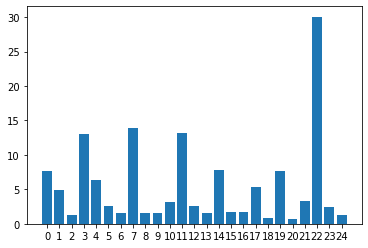

In [10]:
distribution = clf.transform(word_count_matrix)
assignment = np.argmax(distribution, axis=-1)
percs = []
for i in range(topic_count):
    i_topic = data.iloc[assignment == i]
    insincere_perc = len(i_topic[i_topic["target"] == 1]) / len(i_topic) * 100.0
    print("Topic {:d} insincere percentage: {:.2f}%".format(i, insincere_perc))
    percs.append(insincere_perc)

ax = plt.subplot()
ax.bar(range(topic_count), percs)
ax.set_xticks(range(topic_count))
plt.show()

Write some code to calculate and show a bar chart denoting the percentages(and/or count) of each topic contributing to the number of insincere questions.

Specific topics have an disproportionate amount of insincere questions. Use `.sample` to take some questions from the topic with the highest and lowest percentage of insincere questions.

In [11]:
state = 5

highest_idx = 22
highest_samples = data.iloc[assignment == highest_idx].sample(n=10, random_state=state)
print("Highest topic samples:\n\t{:s}".format("\n\t".join(highest_samples["raw_text"])))
lowest_idx = 20
lowest_samples = data.iloc[assignment == lowest_idx].sample(n=10, random_state=state)
print("Lowest topic samples:\n\t{:s}".format("\n\t".join(lowest_samples["raw_text"])))

Highest topic samples:
	Are Chinese people feeling superior like before over Whites now that they reclaimed the world?
	Is it correct using the word 'Islamist' when talking about people? Shouldn't it be Muslim?
	Why do Palestinians blame other Arabs for their miseries and hate them and not blame themselves?
	How do I gain respect after I made myself look stupid?
	Is one a bigot for holding a religion accountable, i.e. protesting Muslims’ death penalty for apostasy?
	What happened to Jewish converts ("non-racial Jews") during the Nazi period?
	What are some examples of relativistic beliefs?
	Do you like dark humor? Why or why not?
	Is it possible that women will get right to kill men because of radical feminism in the future?
	If aliens discovered us, what would they think about us?
Lowest topic samples:
	Do monitor lizards climb trees?
	Does TCS Kolkata hire MBA fresher?
	What is Nawaz Sharif planning by giving such an explosive interview? Is it just revenge?
	Does anyone need blockcha

### Alternative: Build the topic model on solely insincere data

Flipping the question since we now know that insincere questions tend to gravitate toward specific topics: Can we instead isolate the specific topics directly from the insincere portions of the data? Let's try it out. 

Build the same topic model and extract related topics just as above.

In [12]:
insincere_data = df[df["target"] == 1]
# Construct the CountVectorizer and create word count matrix
insincere_vectorizer = CountVectorizer(max_df=0.98, min_df=5, ngram_range=(1, 2), stop_words="english")
insincere_word_count_matrix = insincere_vectorizer.fit_transform(insincere_data["tokenized_text"])
# Fit transform the LDA model on the word count
insincere_clf = LatentDirichletAllocation(n_components=topic_count, random_state=0).fit(insincere_word_count_matrix)

In [13]:
for topic_idx, topic in enumerate(insincere_clf.components_):
    top_words = retrieve_top_words(topic, insincere_vectorizer.get_feature_names(), n_top_words=10)
    print("Topic #{:d}: {:s}".format(topic_idx, ", ".join(top_words)))

Topic #0: people, hate, states, indians, united, british, united states, indian, north, south
Topic #1: like, did, just, looking, obama, japanese, media, sexual, dumb, wrong
Topic #2: jews, did, years, democrats, die, people, know, tax, 000, money
Topic #3: gun, left, right, control, rights, human, guns, does, wing, change
Topic #4: people, just, want, think, life, poor, ask, good, chinese, transgender
Topic #5: like, bad, israel, sex, does, female, look, palestinians, having, dog
Topic #6: old, year, americans, year old, african, illegal, immigrants, american, average, girl
Topic #7: chinese, china, penis, big, does, asians, dick, like, ass, suck
Topic #8: north, blacks, south, day, korea, hindi, mental, north korea, language, india
Topic #9: liberals, woman, conservatives, ca, man, does, like, just, say, conservative
Topic #10: trump, president, donald, donald trump, obama, does, supporters, president trump, trump supporters, did
Topic #11: men, women, white, black, asian, feminists,

### Analysis

From the distribution above, we can clearly detect some words that are hotbeds for inflamatory purpose, for example, *"trump"*. Let's plug it back into our dataset as a keywords and see how many insincere questions are asked with it and how many isn't.

Set `safe_check` to False to trade accuracy for speed.

In [14]:
def keyword_percentage(dataframe, word, safe_check=True):
    if(safe_check):
        checker_fn = lambda text: word in text.lower().strip().split()
    else:
        checker_fn = lambda text: word in text.lower()
    contain = dataframe[dataframe["tokenized_text"].map(checker_fn)]
    try:
        return float(len(contain[contain["target"] == 1])) / len(contain)
    except ZeroDivisionError:
        return 0.0

test_keyword = "trump"
print("Percentage for keyword \"{:s}\": {:.2f}%".format(test_keyword, keyword_percentage(data, test_keyword) * 100.0))

Percentage for keyword "trump": 43.59%


We could easily streamline the process for the topic words generated from the model. With **3** best words per topic, display the above insincere percentage for each of them in another <u>bar chart</u>.

In [15]:
top_3_words = []
percents = []

for topic_idx, topic in enumerate(clf.components_):
  top_words = list(retrieve_top_words(topic, vectorizer.get_feature_names(), n_top_words=3))
  
  for top_word in top_words:
    percent = keyword_percentage(data, top_word) * 100.0
    percents.append(percent)
    print("Percentage for keyword \"{:s}\": {:.2f}%".format(top_word, percent))
  
  top_3_words += top_words

Percentage for keyword "love": 9.19%
Percentage for keyword "day": 5.60%
Percentage for keyword "sex": 28.24%
Percentage for keyword "did": 9.58%
Percentage for keyword "life": 3.80%
Percentage for keyword "university": 1.32%
Percentage for keyword "car": 2.25%
Percentage for keyword "start": 3.83%
Percentage for keyword "process": 1.44%
Percentage for keyword "india": 9.41%
Percentage for keyword "indian": 21.91%
Percentage for keyword "countries": 17.33%
Percentage for keyword "quora": 21.03%
Percentage for keyword "stop": 11.67%
Percentage for keyword "questions": 17.89%
Percentage for keyword "things": 5.49%
Percentage for keyword "business": 2.05%
Percentage for keyword "make": 6.87%
Percentage for keyword "best": 1.05%
Percentage for keyword "way": 5.04%
Percentage for keyword "learn": 2.18%
Percentage for keyword "world": 13.95%
Percentage for keyword "does": 7.01%
Percentage for keyword "new": 5.10%
Percentage for keyword "best": 1.05%
Percentage for keyword "good": 3.74%
Perce

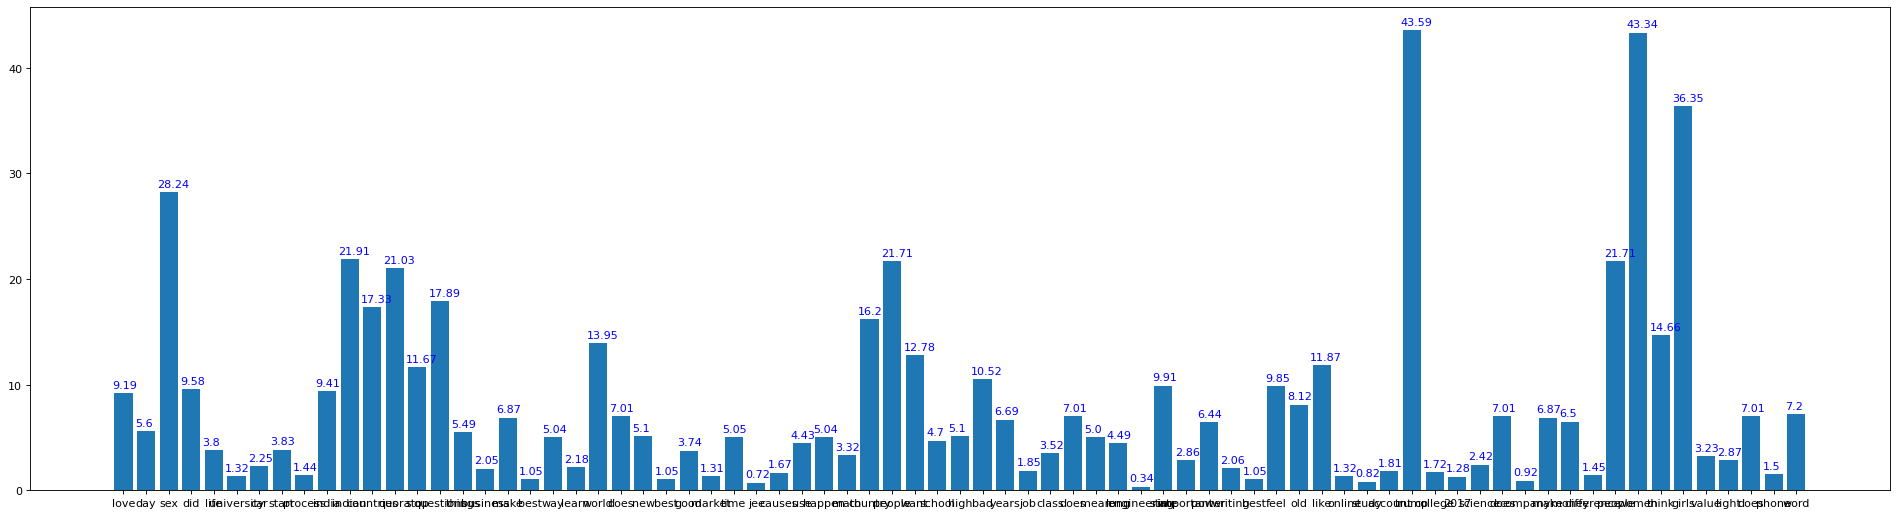

In [16]:
from matplotlib.pyplot import figure

figure(figsize=(30, 8), dpi=80)
ax = plt.subplot()
ax.bar(range(len(top_3_words)), percents)
ax.set_xticks(range(len(top_3_words)))
for i, v in enumerate(percents):
    ax.text(y = v + 0.5, x = i - 0.5, s = str(round(v, 2)), color='blue')

ax.set_xticklabels(top_3_words)
plt.show()

**Optional: sample a number of random keyword (say, 5 of them) in the dataset and draw them on the bar chart along the other values.**

In [17]:
percent_df = pd.DataFrame(np.array([top_3_words, percents])).T
percent_df.columns = ['word', 'percent']

In [18]:
sample_keyword = percent_df.sample(5)
sample_keyword

,word,percent
36,school,4.701792901573362
34,people,21.709284365882958
27,time,5.046587312201863
22,does,7.012912100102055
29,causes,1.6748080949057922


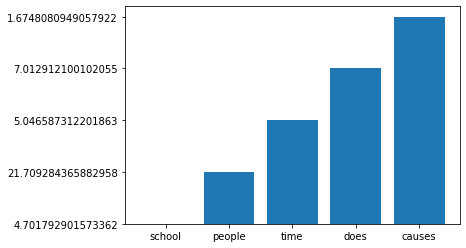

In [19]:
ax = plt.subplot()
ax.bar(range(len(sample_keyword['word'])), sample_keyword['percent'])
ax.set_xticks(range(len(sample_keyword['word'])))
ax.set_xticklabels(sample_keyword['word'])
plt.show()

It is pretty clear that many keywords constitute a fair amount of abuse, with special cases have more than 40% of their question flagged as insincere. These keywords can be used in conjuntion with other classification methods to catch most insincere questions.

## (Optional) Advanced methods and alternatives

### Non-Negative Matrix Factorization
An alternative choice for topic modeling that we haven't had the chance to explore is Non-Negative Matrix Factorization (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF">link</a>). You can redo the above case with this module instead and see if the result improves.

In [20]:
from sklearn.decomposition import NMF
model = NMF(n_components=topic_count, init='random', random_state=0)
W = model.fit_transform(word_count_matrix)
model.components_

array([[4.37161244e-05, 0.00000000e+00, 0.00000000e+00, ...,
        7.36341655e-06, 7.10945018e-06, 6.11655697e-06],
       [3.27617923e-04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.34676615e-05, 1.30031676e-05, 1.11191386e-05],
       [6.49041618e-03, 9.01400529e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [21]:
for topic_idx, topic in enumerate(model.components_):
    top_words = retrieve_top_words(topic, vectorizer.get_feature_names(), n_top_words=10)
    print("Topic #{:d}: {:s}".format(topic_idx, ", ".join(top_words) ))

Topic #0: know, need, things, need know, really, love, people know, girl, does know, want know
Topic #1: did, war, come, start, change, long, face, did people, say, american
Topic #2: like, look, look like, feel like, people like, girls, girl, countries, guy, does like
Topic #3: work, tips, starting, useful, useful tips, starting work, tips starting, experience, company, hard
Topic #4: just, really, ca, love, say, mean, just like, girl, friend, stop
Topic #5: best, best way, online, book, ways, friend, best ways, books, place, best friend
Topic #6: life, real, real life, live, things, day, change, living, important, life like
Topic #7: women, men, indian, white, black, sex, man, girls, woman, men women
Topic #8: year, old, year old, girl, years old, years, old girl, 14, boy, 15
Topic #9: use, using, app, instead, used, phone, data, people use, word, language
Topic #10: good, bad, good bad, idea, business, good idea, books, book, short, term
Topic #11: india, indian, china, pakistan, co

Topic 0 insincere percentage: 3.94%
Topic 1 insincere percentage: 7.15%
Topic 2 insincere percentage: 10.09%
Topic 3 insincere percentage: 2.11%
Topic 4 insincere percentage: 7.00%
Topic 5 insincere percentage: 0.74%
Topic 6 insincere percentage: 2.79%
Topic 7 insincere percentage: 20.75%
Topic 8 insincere percentage: 6.92%
Topic 9 insincere percentage: 1.55%
Topic 10 insincere percentage: 2.64%
Topic 11 insincere percentage: 10.24%
Topic 12 insincere percentage: 3.06%
Topic 13 insincere percentage: 6.44%
Topic 14 insincere percentage: 12.02%
Topic 15 insincere percentage: 16.56%
Topic 16 insincere percentage: 4.53%
Topic 17 insincere percentage: 1.55%
Topic 18 insincere percentage: 2.81%
Topic 19 insincere percentage: 1.52%
Topic 20 insincere percentage: 11.43%
Topic 21 insincere percentage: 10.79%
Topic 22 insincere percentage: 20.99%
Topic 23 insincere percentage: 3.57%
Topic 24 insincere percentage: 4.24%


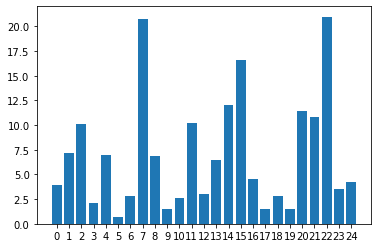

In [22]:
distribution = model.transform(word_count_matrix)
assignment = np.argmax(distribution, axis=-1)
percs = []
for i in range(topic_count):
    i_topic = data.iloc[assignment == i]
    insincere_perc = len(i_topic[i_topic["target"] == 1]) / len(i_topic) * 100.0
    print("Topic {:d} insincere percentage: {:.2f}%".format(i, insincere_perc))
    percs.append(insincere_perc)

ax = plt.subplot()
ax.bar(range(topic_count), percs)
ax.set_xticks(range(topic_count))
plt.show()

### Implementation of Classification

Student who had ran through the previous Classification course can try tackle this problem and see if the new insights offered in this notebook would translate to a higher accuracy score.

In [23]:
from sklearn.linear_model import LogisticRegression
vectorizer = CountVectorizer(max_df=0.98, min_df=5, ngram_range=(1, 2), stop_words="english")
word_count = vectorizer.fit_transform(df["tokenized_text"])
X = word_count
y = df['target']
clf = LogisticRegression(max_iter=20000).fit(X, y)

In [24]:
clf.predict_proba(X)

array([[9.17272657e-01, 8.27273432e-02],
       [9.78640480e-01, 2.13595203e-02],
       [9.99921724e-01, 7.82764710e-05],
       ...,
       [9.89360128e-01, 1.06398716e-02],
       [9.98517464e-01, 1.48253562e-03],
       [9.96978530e-01, 3.02147020e-03]])

In [25]:
clf.score(X, y)

0.9658531132620077